In [1]:
from tqdm import tqdm
import pickle
import re
from collections import Counter
import matplotlib.pyplot as plt

## Read in headers and email from previous processing steps

 - headers processed, i.e. variable values extracted and parsed
 - emails sorted according to time sent in headers
 - bodies processed by removing quoted text from previous emails in conversation

In [2]:
# change to loading emails with body processed as well
with open("headers_and_bodies_processed.pkl", "rb") as handle:
    headers_srtd, mails_srtd = pickle.load(handle)

---
# The WROTE_TO relation


## Filter and extract sender and receiver information

 - remove headers with incomplete sender or receiver information (missing sender email or missing receiver name or email) <br>
   -> each sender and each receiver has name and address 
 - removes around half of all emails; good enough for now, later try filling in missing values from other header fields or email body
 - good news is that the number of unique senders and receivers is much lower than the number of interactions, <br>
   implying that on average, people don't act as senders or receivers only once

In [3]:
def filter_headers(header_ls):
    for h in header_ls:
        if not h["email"]:
            continue
        if not h["to"][0]:
            continue
        if not h["to"][1]:
            continue
        yield h
        

headers_fltrd = list(filter_headers(headers_srtd))
# headers_fltrd = headers_srtd
print("Number of headers before filtering:\t", len(headers_srtd))
print("Number of headers after filtering:\t", len(headers_fltrd))
print()

all_senders = {(h["name"], h["email"]) for h in headers_fltrd}
all_receivers = {h["to"] for h in headers_fltrd}

print("Number of unique senders:\t", len(all_senders))
print("Number of unique receivers:\t", len(all_receivers))
print("Number of unique people:\t", len(all_senders | all_receivers),
"\t\t(overlap:", (len(all_senders | all_receivers)/(len(all_senders) + len(all_receivers))), ")")

Number of headers before filtering:	 143963
Number of headers after filtering:	 65663

Number of unique senders:	 5203
Number of unique receivers:	 8413
Number of unique people:	 11011 		(overlap: 0.8086809635722679 )


## Uniqueness of email addresses <br> (i.e. the usability of email addresses as unique identifiers)

 - it turns out that for some email addresses, there are multiple users of that address
 - it seems that these are mainly support addresses and mailing list addresses
 - -> to ensure uniqueness, for now we use both name and address as person identifier

In [4]:
addresses = {}

for h in headers_fltrd:
    if not h["email"] in addresses:
        addresses[h["email"]] = set()
    addresses[h["email"]].add(h["name"])
    
    if not h["to"][1] in addresses:
        addresses[h["to"][1]] = set()
    addresses[h["to"][1]].add(h["to"][0])
    
print("Number of unique addresses:\t\t", len(addresses))
print("Number of addresses with single user:\t", len([v for v in addresses.values() if len(v) == 1]))

len_sorted = sorted(addresses.items(), key=lambda kv: len(kv[1]), reverse=True)

print()
print("Addresses with the most users:\n")
for addr, name_set in len_sorted[:5]:
    print("  Address:\t", addr)
    print("  Number of users:\t", len(name_set))
    print("  Sample from set of users:\t",list(name_set)[:5])
    print()

Number of unique addresses:		 8267
Number of addresses with single user:	 6902

Addresses with the most users:

  Address:	 w3c-wai-ig@w3.org
  Number of users:	 105
  Sample from set of users:	 ["W3c-Wai-Ig list (E-mail)'", '1-W3C-WAI Interest Group', "'WAI Mailing list (E-mail)'", 'WAI IG List', "'W3c_Access'"]

  Address:	 w3c-wai-gl@w3.org
  Number of users:	 84
  Sample from set of users:	 ['wai wac', "'WCAG (E-mail)'", "'w3c-wai-gl@w3.org'", 'gl', "'GLWAI Guidelines WG (GL - WAI Guidelines WG)'"]

  Address:	 www-amaya@w3.org
  Number of users:	 52
  Sample from set of users:	 ['Amaya Forum', 'Amaya (Request)', "'amaya maillist'", 'ML Amaya', 'Amaya Mailingliste']

  Address:	 w3c-wai-eo@w3.org
  Number of users:	 50
  Sample from set of users:	 ['eowg', 'WAI Education&Outreach Working Group', 'Education&Outreach', 'w3c-wai-eo', 'W3c-Wai-Eo (w3c-wai-eo@w3.org)']

  Address:	 html-tidy@w3.org
  Number of users:	 46
  Sample from set of users:	 ['Html-tidy', "'Dave Raggett'", "'Htm

## Collect the actual instances of the relation WROTE_TO

 - i.e. a tuple of: 1) sender (name, email) and 2) receiver (name, email)

In [5]:
relation_tuples = [((h["name"], h["email"]), h["to"]) for h in headers_fltrd]

print("Number of instances:\t\t", len(relation_tuples))
print("Number of unique instances:\t", len(set(relation_tuples)))

Number of instances:		 65663
Number of unique instances:	 24412


## Basic stats about the WROTE_TO relation

 1. frequencies of unique relation instances, i.e. how many times a pair of sender and receiver occurs


Most common tuples:
  (('CVS Update Notifier', 'nobody@w3.org'), ('CVS Notify', 'public-ws-desc-eds@w3.org')):		830 times
  (('Charles McCathieNevile', 'charles@w3.org'), ('WAI AU Guidelines', 'w3c-wai-au@w3.org')):		493 times
  (('Judy Brewer', 'jbrewer@w3.org'), ('EOWG', 'w3c-wai-eo@w3.org')):		389 times
  (('Brian McBride', 'bwm@hplb.hpl.hp.com'), ('RDF Core', 'w3c-rdfcore-wg@w3.org')):		248 times
  (('Brian McBride', 'bwm@hplb.hpl.hp.com'), ('rdf core', 'w3c-rdfcore-wg@w3.org')):		210 times




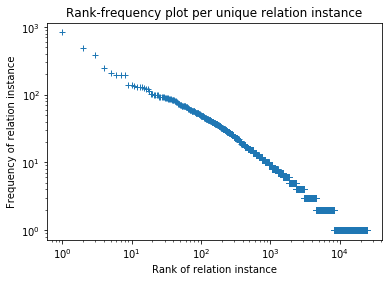

In [6]:
freqs = Counter(relation_tuples)
print("Most common tuples:")
for rt, f in Counter(relation_tuples).most_common(5):
    print(f"  {rt}:\t\t{f} times")
    
print("\n")
plt.loglog(list(range(1, len(freqs)+1)), [c for t, c in freqs.most_common()], '+')
plt.title("Rank-frequency plot per unique relation instance")
plt.xlabel("Rank of relation instance")
plt.ylabel("Frequency of relation instance")
plt.show()

 2. frequencies of unique sender instances, i.e. how many times each person acted as sender

Most common senders:
  ('Charles McCathieNevile', 'charles@w3.org'):		3954 times
  ('Brian McBride', 'bwm@hplb.hpl.hp.com'):		1471 times
  ('Dan Connolly', 'connolly@w3.org'):		979 times
  ('Patrick Stickler', 'patrick.stickler@nokia.com'):		953 times
  ('Ian Jacobs', 'ij@w3.org'):		847 times




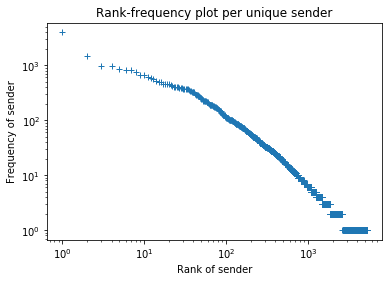

In [7]:
freqs = Counter([send for send, rec in relation_tuples])
print("Most common senders:")
for rt, f in freqs.most_common(5):
    print(f"  {rt}:\t\t{f} times")
    
print("\n")
plt.loglog(list(range(1, len(freqs)+1)), [c for t, c in freqs.most_common()], '+')
plt.title("Rank-frequency plot per unique sender")
plt.xlabel("Rank of sender")
plt.ylabel("Frequency of sender")
plt.show()

## Write collected relation instances to a pickle file for later graph construction

In [8]:
with open("WROTE_TO.pkl", "wb") as handle:
    pickle.dump(relation_tuples, handle)

---
# TODO: The REFERRED_TO relation

 - collect all unique resource identifiers (links, email addresses, etc) from email body
 - for each of these URIs, the tuple of sender and that URI is an instance of the relation REFERRED_TO
 - regex patterns below cathc (almost) all email addresses and http links

In [9]:
# email address and link extraction
email_address_pattern = re.compile(r'[\w\.-]+@[\w\.-]+')
url_pattern = re.compile(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")